In [114]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Generate 2d Swiss Roll
`n_samples` is the number of data points.

`noise` is the standard deviation of the Gaussian noise.

`t` is a 2D array with shape (1, n_samples). It is filled with random numbers uniformly distributed in the range (3π, 9π).

`x` and `y` are the coordinates of the points in the Swiss roll.

`X` is the final data matrix. It is a 2D array with shape (n_samples, 2), where each row is a point in the Swiss roll.

In [115]:
# Create a 2D Swiss roll
def create_swiss_roll(batch_size=100):
    n_samples = 1000
    noise = 1

    swiss_rolls = []
    
    for i in range(batch_size):
        t = 3.0 * np.pi * (1 + 2 * torch.rand(1, n_samples))
        x = t * torch.cos(t)
        y = t * torch.sin(t)

        X = torch.cat((x, y), dim=0)
        X += noise * torch.randn(2, n_samples)
        X = X.T
        swiss_rolls.append(X)

    swiss_rolls = torch.stack(swiss_rolls)  # 将张量列表堆叠为一个张量
    
    return swiss_rolls

torch.Size([2, 1000, 2])


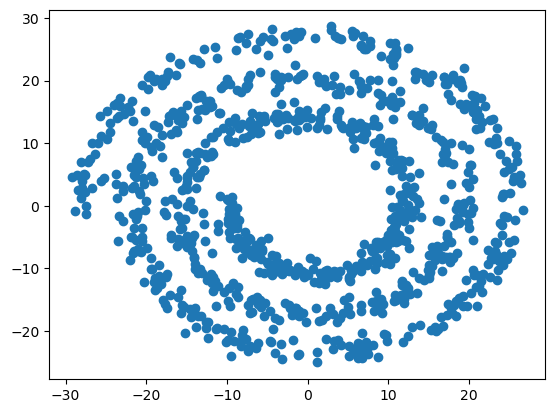

In [116]:
swiss_rolls = create_swiss_roll(2)
print(swiss_rolls.shape)
# Plot the Swiss roll
plt.scatter(swiss_rolls[0, :, 0], swiss_rolls[0, :, 1])
plt.show()

## Denosing Diffusion Probabilistic Model

In [145]:
class DDPM:
    def __init__(self, n_steps):
        super().__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.n_steps = n_steps
        self.beta = torch.linspace(0.001, 0.01, self.n_steps).to(self.device)
        self.alpha = 1- self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        self.sigma = self.beta
        
    def forward_process(self, x0, t):
        eps = torch.rand(*x0.shape).to(self.device)
        xt = torch.sqrt(self.alpha_hat[t]) * x0 + torch.sqrt(1 - self.alpha_hat[t]) * eps
        return xt, eps
    
    def sampling(self, xt, t, model):
        sampling_results = []
        # 计算x_{t-1},...,x0
        for i in range(t-1, 0, -1):
            z = torch.rand(*xt.shape).to(self.device)
            
            xt = xt.view(-1, 1, 1000, 2).to(self.device)
            
            eps_theta = model(xt, t).to(self.device)
            xt = 1. / torch.sqrt(self.alpha_hat[i]) * (xt - self.beta[i] / torch.sqrt(1 - self.alpha_hat[i] * eps_theta)) + self.sigma[i] * z
            # 存放结果
            sampling_results.append(xt)
        # 翻转后sampling_results[t]即采样步骤中的xt
        sampling_results.reverse()
        sampling_results = torch.stack(sampling_results)
        
        return sampling_results
    
    def train(self):
        swiss_rolls = create_swiss_roll(batch_size=200).to(self.device)
        
        model = EPS().to(self.device)
        
        criterion = nn.MSELoss()
        
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        
        epoch_num = 1
        for i in range(epoch_num):
            for x0 in swiss_rolls:
                eps_seq = []
                eps_theta_seq = []
                for t in range(1, self.n_steps):
                    xt, eps = self.forward_process(x0, t)
                    xt = xt.to(self.device)
                    eps = eps.to(self.device)
                    
                    xt = xt.view(-1, 1, 1000, 2)
                    
                    eps_theta = model(xt, t)
                    eps_seq.append(eps)
                    eps_theta_seq.append(eps_theta)

                eps_seq = torch.stack(eps_seq)
                eps_theta_seq = torch.stack(eps_theta_seq)

                loss = criterion(eps_theta_seq, eps_seq)
                print(f'loss:{loss.item()}')
                loss.backward()

                optimizer.step()
                optimizer.zero_grad()
        
        print('Over!')
        
        noise = torch.rand(*swiss_rolls[0].shape).to(self.device)
        sampling_results = self.sampling(noise, self.n_steps, model)
        return sampling_results
    
        

In [146]:
class EPS(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 3, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(3, 8, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(8, 1, 3, 1, 1)
        )
    
    def forward(self, xt, t):
        xt = xt + t
        return self.layers(xt)

## Run

In [147]:
ddpm_model = DDPM(30)

In [148]:
sampling_results = ddpm_model.train()

loss:1.1359561681747437
loss:0.39253365993499756
loss:0.39410868287086487
loss:0.3932459056377411
loss:0.318409264087677
loss:0.24806903302669525
loss:0.1899615377187729
loss:0.16273963451385498
loss:0.13952983915805817
loss:0.12700484693050385
loss:0.12226278334856033
loss:0.11538408696651459
loss:0.11373576521873474
loss:0.11199256777763367
loss:0.11030960083007812
loss:0.10959828644990921
loss:0.10750464349985123
loss:0.10296138375997543
loss:0.10373859107494354
loss:0.10352305322885513
loss:0.100265271961689
loss:0.10160612314939499
loss:0.09839362651109695
loss:0.09894175082445145
loss:0.09742501378059387
loss:0.09635069221258163
loss:0.09768547117710114
loss:0.09680283069610596
loss:0.09522693604230881
loss:0.09563078731298447
loss:0.09438008069992065
loss:0.09425655752420425
loss:0.09347279369831085
loss:0.09285205602645874
loss:0.0920834019780159
loss:0.09261257946491241
loss:0.09241983294487
loss:0.09132815897464752
loss:0.09110148996114731
loss:0.09159031510353088
loss:0.0907

In [149]:
sampling_results.shape

torch.Size([29, 1, 1, 1000, 2])

In [150]:
sampling_results[-1].shape

torch.Size([1, 1, 1000, 2])

In [152]:
results = sampling_results[-1][0, 0, :, :]

In [158]:
results = results.cpu().detach()

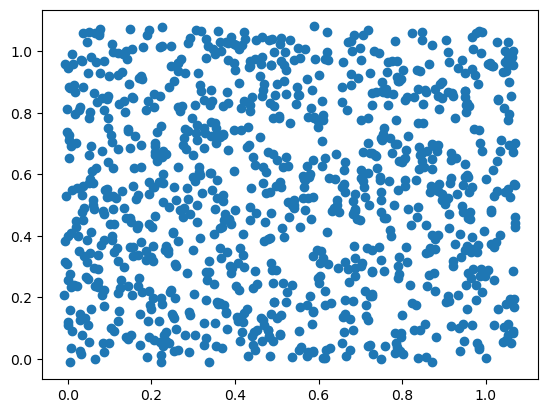

In [159]:
plt.scatter(results[:, 0].numpy(), results[:, 1].numpy())
plt.show()